# Pytorch NN:

Source: https://www.youtube.com/watch?v=Jy4wM2X21u0&list=PLhhyoLH6IjfxeoooqP9rhU3HJIAVAJ3Vz&index=4

### Procedure:

imports

create fully connected nn

set device

hyperparameters

load data

Initialize network

loss and optimizer

train network

check accuracy - on both train and test set

In [4]:
#imports
import torch
import torch.nn as nn 

import torch.optim as optim
#optimizer; helps reduce loss fcn

import torch.nn.functional as F
#F contains activation functions like RelU - but they are also contained
#in the nn package. can use either

from torch.utils.data import DataLoader
# easier dataset management - gives us minibatches to train on

import torchvision.datasets as datasets
#will be used to import standard datasets like MNIST

import torchvision.transforms as transforms
#essentially has tranformations we can perform on our dataset

In [5]:
#creating the Fully connected NN
class NN(nn.Module): #inherit the Module
    def __init__(self, input_size, num_classes): 
        super().__init__() #run constructor of nn.Module - inherit
        
        #layers we want to include in our NN:
        self.fc1 = nn.Linear(input_size, 50)
        #MNIST Dataset: 28x28 = 784 images => 784 nodes
        #or setting number of hidden nodes to 50
        
        
        #layer 2-> goes from 50 (hidden layer neurons) to number of classes
        self.fc2 = nn.Linear(50, num_classes)
    
    def forward(self, x): #forward runs on input x
        z = self.fc1(x)
        y_p = F.relu(z) #non-linearization
        y_p = self.fc2(y_p) #Reaches output layer
        return y_p
    
#testing if model works for some random inputs:

model = NN(784, 10)
#784 - number of images in MNIST
#10 - number of digits
x = torch.randn(64, 784)
#64 - number of examples we are going to run simultaneously
#number of images essentially

print(model(x).shape) 
#print the shape of the output - we want 64x10
# probability of number/picture i belonging to class j

torch.Size([64, 10])


In [7]:
#set device:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [8]:
#set hyperparameters:
input_size = 784
number_of_classes = 10
l_rate = 0.001
batch_size = 64
num_epochs = 1

In [36]:
#load the data

transformer = transforms.ToTensor() 
#transforms data to a tensor

trainset = datasets.MNIST(root='datasets/', train=True,\
                          transform = transformer, download = True)
#root - where the dataset should be saved; 
#here, creates and saves in a folder called datasets
#download = True -> will download dataset if we don't have it

trainloader = DataLoader(dataset = trainset, batch_size = batch_size,\
                         shuffle = True)
#shuffle -> shuffles images in the batches between epochs
#=> every epoch, the images in a batch changes

testset = datasets.MNIST(root='datasets/', train=False,\
                          transform = transformer, download = True)
testloader = DataLoader(dataset = testset, batch_size = batch_size,\
                         shuffle = True)

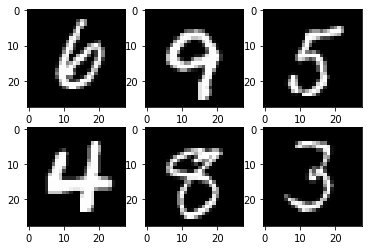

In [21]:
#my own code: 
#taking a look at the data

examples = iter(testloader)
e_data, e_label = examples.__next__() #gets next batch of data

import matplotlib.pyplot as plt
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(e_data[i][0], cmap='gray')
plt.show()

In [12]:
#initialize the network
model = NN(input_size = input_size, num_classes = number_of_classes)\
.to(device)

In [14]:
#loss function and optimizer

criterion = nn.CrossEntropyLoss() 
#loss function for logistic regression - predicting which of 10 classes
#given image belongs to

optimizer = optim.Adam(model.parameters(), lr = l_rate)

In [23]:
#train the network:

#one epoch - model has seen all images in trainset
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(trainloader): 
        #ip and op/correct label - data, targets
        #enumerate - gives us batch index of data too
        
        #checking if data is in correct shape:
        """original shape of images : [batch_size, 1, 28, 28]
        can find this out by printing:
        print(data.shape) - prints shape of data for each batch
        need it to be of shape [batch_size, 784]"""
        
        data = data.reshape(data.shape[0], -1) 
        #-1 flattens everything else to a single dimension
        # print(data.shape) - torch.Size([64, 784]) for each batch
        
        #first, transfer the data and labels to device
        data = data.to(device)
        targets = targets.to(device)
        
        #forward - inputs go through all layers in the model - 1 pass
        scores = model(data)
        #data is not in size expected for fc1
        #fc1 - 784 ip nodes 
        #data - 1 batch of 64 instances/images each with 28x28 image size
        
        #after performing forward opr - or one pass of data
        #calculate the loss
        loss = criterion(scores, targets) #pred, actual
        
        #set all gradients to zero 
        #to properly calc gradients during backward pass
        optimizer.zero_grad()
        #makes sure it is not storing backprop values from prev batch
        
        #backward prop
        #go backward - back to start for the next batch
        #also calculate all gradients along the way
        loss.backward()
        
        #gradient descent or adam step - performs a single optim step
        #updates the parameters of model based on gradients and backward pass
        optimizer.step()

for i, j in testloader:
    print(i.shape, j.shape)
    i = i.reshape(i.shape[0], -1)
    print(i.shape, j.shape)
    break

In [41]:
#evaluate the network:

def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    
    model.eval() #puts the model in eval mode - behaves a bit diffirently
    
    with torch.no_grad(): #gradients dont need to be computed during testing
        for x, y in loader: #iterates through every batch
            #x = x.to(device)
            #y = y.to(device)
            x = x.reshape(x.shape[0], -1)
            
            scores = model(x)
            #shape of scores will be 64x10 - 64 inputs 10 classes
            #10 - contains prob of img being of that class
            
            #want to know which of the 10 has maximum prob
            
            #print(scores.max(1)) - torch.return_types.max(values=tensor([7.3685]),indices=tensor([7]))
            
            _, predictions = scores.max(1) #computes max along dim=1
            #this gives us the value, index but we're not interested 
            #in the value, only the index
            
            
            num_correct += (predictions == y).sum()
            #for every x, y (every batch), adds total number of 'true' preds
            
            num_samples += predictions.size(0) #adds batch size every itr
        
        #after 1 epoch - 1 pass through all batches:
        acc = num_correct/num_samples
        print(f" accuracy = {num_correct}/{num_samples} = {acc} = {acc*100}%")
        
        #return model to train if necessary:
        model.train()
        #done when you're checking accuracy of model in the 
        #middle of training
        
        return acc
        
acc1 = check_accuracy(trainset, model)
acc2 = check_accuracy(testset, model)

 accuracy = 55794/60000 = 0.9298999905586243 = 92.98999786376953%
 accuracy = 9316/10000 = 0.9315999746322632 = 93.15999603271484%


Note: 
dim 0 -> rows;
dim 1 -> cols;

# Pytorch CNN:

CNNs work a lot better on image datasets than NN

In [51]:
class CNN(nn.Module):
    def __init__(self, in_channels = 1, num_classes= 10):
        super().__init__()
        #define all the layers to be used in the network
        
        #Feature extractor layers:
        
        #creating convolutional layer:
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 8, \
                             kernel_size= 3, stride = 1)
        #in_channels = 1 -> greyscale img
        #out_channels - number of channels in output of this layer
                # set to an arbitrary number - 8
            
        #can use ReLU here
        
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        #makes a 28x28 image into 14x14 and 14x14 into 7x7 image
        
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, \
                             kernel_size= 3, stride = 1)
        
        #classification head:
        self.fc1 = nn.Linear(16*5*5, num_classes)
        #input_size = 16 channels * 7x7 image 
        #shape of x after feature extraction:  torch.Size([64, 16, 5, 5])
        #so changing 7*7 into 5*5
        
    def forward(self, x):
        #feature extraction:
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        print("shape of x after feature extraction: ", x.shape)
        
        #classification:
        x = x.reshape(x.shape[0], -1) #number of batches, pixels
        x = self.fc1(x)
        
        return x

In [52]:
model = CNN()
x_test = torch.randn(64, 1, 28, 28) #inital size of each batch in MNIST
# we plan on setting batch size 64
print(x_test.shape)
print(model(x_test).shape)

#got the desired shape of 64 x 10

torch.Size([64, 1, 28, 28])
shape of x after feature extraction:  torch.Size([64, 16, 5, 5])
torch.Size([64, 10])


In [54]:
#can now train the network:
#and check accuracy

# Saving and Loading datasets:

In [55]:
model = NN(784, 10) #just setting model to the NN example

In [58]:
#user defined function to save checkpoint
def save_checkpoint(state, filename='my_checkpoint.pth.tar'):
    torch.save(state, filename)

In [59]:
#while training, can enter this code:

checkpoint = {'model': model.state_dict(), 'optimizer' : optimizer.state_dict()}
#saves current vallues of all params - or the current state dict

save_checkpoint(checkpoint)
#user defined function

In [60]:
for key, value in checkpoint.items():
    print(key)
    print(value)
    print()

model
OrderedDict([('fc1.weight', tensor([[-0.0079, -0.0074, -0.0336,  ...,  0.0105,  0.0202, -0.0100],
        [-0.0111,  0.0177, -0.0288,  ..., -0.0152,  0.0020,  0.0244],
        [-0.0195, -0.0243,  0.0164,  ...,  0.0121, -0.0251, -0.0141],
        ...,
        [ 0.0031,  0.0082, -0.0324,  ...,  0.0009, -0.0177,  0.0300],
        [-0.0071,  0.0199,  0.0345,  ...,  0.0009, -0.0020,  0.0282],
        [-0.0237, -0.0203, -0.0084,  ..., -0.0134, -0.0203, -0.0165]])), ('fc1.bias', tensor([-0.0114,  0.0086, -0.0136,  0.0278,  0.0050,  0.0327, -0.0219, -0.0289,
        -0.0116, -0.0031,  0.0226,  0.0145,  0.0246, -0.0317, -0.0034,  0.0319,
         0.0240,  0.0275, -0.0158, -0.0232,  0.0244, -0.0209, -0.0223, -0.0040,
         0.0186,  0.0243,  0.0095, -0.0096, -0.0036,  0.0271, -0.0093, -0.0129,
        -0.0218, -0.0230,  0.0040,  0.0002, -0.0193,  0.0110,  0.0101, -0.0102,
        -0.0031,  0.0303, -0.0290, -0.0333, -0.0209, -0.0222, -0.0243, -0.0158,
         0.0114, -0.0195])), ('fc2.we

        -0.1068, -0.0470]))])

optimizer
{'state': {0: {'step': tensor(938.), 'exp_avg': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 'exp_avg_sq': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])}, 1: {'step': tensor(938.), 'exp_avg': tensor([ 2.0878e-04,  5.6052e-45, -3.6323e-04, -5.6135e-04,  2.5027e-03,
        -1.3808e-03, -5.9705e-04, -1.0966e-03,  4.2360e-05,  2.0591e-03,
         9.9269e-13,  3.4056e-04, -4.8536e-04, -5.5165e-04,  3.3153e-04,
        -2.0003e-03, -2.9905e-05,  2.0644e-03,  5.5347e-05, -1.6789e-03,
         6.9984e-04,  1.1405e-03, -1.3198e-03, -1.6525e-0

        1.2201e-04, 1.6426e-04, 2.6061e-04, 2.5889e-04])}}, 'param_groups': [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': False, 'params': [0, 1, 2, 3]}]}



now the checkpoint has been saved as a file in the given path

In [61]:
#loading the checkpoint:

def load_checkpoint(checkpoint):
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    
#can even save accuracy and such in the checkpoint dict

In [64]:
load_checkpoint(torch.load("my_checkpoint.pth.tar"))
#loads the model and optimizer values
#torch.load(filename) -> given as checkpoint valued for function